In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate, Multiply, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from keras.metrics import MeanSquaredError, Precision
from sklearn.metrics import mean_squared_error

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_ratings = pd.read_pickle('/content/drive/My Drive/df_ratings_100k.pkl')
df_movies = pd.read_pickle('/content/drive/My Drive/df_movies_cleaned.pkl')

# 1. Preprocessing

## 1.1 Convert UserId & MovieId

In a collaborative filtering model, user IDs and movie IDs need to be converted to a continuous range of integers, which will serve as array indices in the embedding layers. Neural network models, particularly those using embeddings, benefit from having user and movie indices start from zero and continue without gaps. This is because each index directly accesses a position in the embedding matrix. This step ensures that each user and movie can be uniquely identified with a dense vector in the latent space.

In [ ]:
# Combine all movie IDs and user IDs from both dataframes to ensure comprehensive encoding
all_movie_ids = pd.concat([df_ratings['movieId'], df_movies['movieId']]).unique()
all_user_ids = df_ratings['userId'].unique()

# Create and fit the encoders
movie_encoder = LabelEncoder()
user_encoder = LabelEncoder()

movie_encoder.fit(all_movie_ids)
user_encoder.fit(all_user_ids)

# Transform movie and user IDs in the both dataframes
df_ratings['user'] = user_encoder.transform(df_ratings['userId'])
df_ratings['movie'] = movie_encoder.transform(df_ratings['movieId'])
df_movies['movie'] = movie_encoder.transform(df_movies['movieId'])

In [ ]:
# Check Encoding:

num_users = df_ratings['user'].nunique()
num_movies = df_ratings['movie'].nunique()

print("Unique users in ratings:", num_users)
print("Unique movies in ratings:", num_movies)
print("Min/Max user IDs:", df_ratings['user'].min(), '/', df_ratings['user'].max())
print("Min/Max movie IDs:", df_ratings['movie'].min(), '/', df_ratings['movie'].max())

Unique users in ratings: 55588
Unique movies in ratings: 9494
Min/Max user IDs: 0 / 55587
Min/Max movie IDs: 0 / 39082


User IDs appear to be correctly encoded. We have 55,588 unique users, and the user IDs range from 0 to 55,587, which suggests that every unique user ID has been mapped to a unique integer in a contiguous zero-based range.

Movie IDs, however, show a discrepancy. While there are 9,494 unique movies, the movie IDs range from 0 to 39,082. This gap indicates that not all possible integer values between 0 and 39,082 are used, suggesting that there are missing IDs within this range. Therefore, we will remap the movie IDs to a new contiguous range.

In [ ]:
# Recreate the mapping from the sorted unique IDs
movie_id_map = {id: i for i, id in enumerate(sorted(df_ratings['movieId'].unique()))}

# Apply the new mapping to the DataFrames
df_ratings['movie'] = df_ratings['movieId'].apply(lambda x: movie_id_map.get(x, -1))  # Use get to avoid errors
df_movies['movie'] = df_movies['movieId'].apply(lambda x: movie_id_map.get(x, -1))

# Check again
print("New max movie ID in ratings:", df_ratings['movie'].max())
print("New unique movie IDs in ratings:", df_ratings['movie'].nunique())

New max movie ID in ratings: 9493
New unique movie IDs in ratings: 9494


In [ ]:
print(df_ratings[['movieId', 'movie']].head())
print(df_movies[['movieId', 'movie']].head())

          movieId  movie
11800835     1037    829
3192182     27316   5716
10041143      307    269
14911364    73929   7389
13024846     4308   3281
   movieId  movie
0        1      0
1        2      1
2        3      2
3        4      3
4        5      4


The mapping has now been applied correctly. The movie IDs now range from 0 to 9493, which matches exactly with the count of unique movie IDs (9494), implying that the IDs are perfectly contiguous and zero-indexed. Let's do a final validation check to confirm that no movieId is left unmapped and no erroneous transformations have occurred:

In [ ]:
# Ensure that all movies referenced in ratings are available in the movies DataFrame
missing_movies = df_ratings[~df_ratings['movie'].isin(df_movies['movie'])]
if missing_movies.empty:
    print("All movies in ratings are accounted for in the movies dataframe.")
else:
    print(f"There are {missing_movies.shape[0]} missing movies in the movies dataframe.")

There are 781 missing movies in the movies dataframe.


The presence of 781 missing movies in the df_movies DataFrame compared to df_ratings indicates that there are movies which have been rated but for which there is no additional metadata available in the df_movies dataset. Those rows will be dropped as they are not significant for the model.

In [ ]:
# Removing ratings with missing movie metadata
df_ratings = df_ratings[df_ratings['movie'].isin(df_movies['movie'])]

# Check again
missing_movies_after = df_ratings[~df_ratings['movie'].isin(df_movies['movie'])]
if missing_movies_after.empty:
    print("All movies in ratings are now accounted for in the movies dataframe.")
else:
    print(f"There are still {missing_movies_after.shape[0]} missing movies in the movies dataframe.")

All movies in ratings are now accounted for in the movies dataframe.


The data is now correctly encoded and we can move on to the next preprocessing step.

## 1.2 Normalize Ratings

Next, we normalize the ratings as this helps the model train faster and converge more easily.

In [ ]:
# Normalize the ratings to a scale of 0 to 1
df_ratings['rating_norm'] = (df_ratings['rating'] - 0.5) / 4.5

<ipython-input-48-e3f3ccd1ac68>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ratings['rating_norm'] = (df_ratings['rating'] - 0.5) / 4.5


In [ ]:
# Check Normalization:

print("Min/Max normalized ratings:", df_ratings['rating_norm'].min(), "/", df_ratings['rating_norm'].max())
print(df_ratings[['rating', 'rating_norm']].head())

Min/Max normalized ratings: 0.0 / 1.0
          rating  rating_norm
11800835     0.5          0.0
3192182      0.5          0.0
10041143     0.5          0.0
14911364     0.5          0.0
13024846     0.5          0.0


## 1.3 Prepare Data for Modelling

Now, we split the data into training and test data. For recommendation tasks, a chronological split makes more sense than a random split because user preferences and item popularity can change over time. Using a chronological split can simulate a real-world scenario where a model trained on past data is used to predict future preferences. This approach helps in evaluating how well the model might perform when deployed in production, as it mimics the model's need to work with new, unseen data arriving over time.

In [ ]:
# Sort data chronologically
df_ratings = df_ratings.sort_values(by='timestamp')

# Define split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Define a cutoff for splitting the data (70% train, 15% validation, 15% test)
train_cutoff = int(len(df_ratings) * train_ratio)
val_cutoff = int(len(df_ratings) * (train_ratio + val_ratio))

train_df = df_ratings.iloc[:train_cutoff]
val_df = df_ratings.iloc[train_cutoff:val_cutoff]
test_df = df_ratings.iloc[val_cutoff:]

In [ ]:
# Separate user and item IDs for training, validation, and testing
X_train_user = train_df['user'].values
X_train_item = train_df['movie'].values
y_train = train_df['rating_norm'].values

X_val_user = val_df['user'].values
X_val_item = val_df['movie'].values
y_val = val_df['rating_norm'].values

X_test_user = test_df['user'].values
X_test_item = test_df['movie'].values
y_test = test_df['rating_norm'].values

# Convert to TensorFlow tensors
X_train_user = tf.convert_to_tensor(X_train_user, dtype=tf.int32)
X_train_item = tf.convert_to_tensor(X_train_item, dtype=tf.int32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)

X_val_user = tf.convert_to_tensor(X_val_user, dtype=tf.int32)
X_val_item = tf.convert_to_tensor(X_val_item, dtype=tf.int32)
y_val = tf.convert_to_tensor(y_val, dtype=tf.float32)

X_test_user = tf.convert_to_tensor(X_test_user, dtype=tf.int32)
X_test_item = tf.convert_to_tensor(X_test_item, dtype=tf.int32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

In [ ]:
# Verify the shapes of the tensors
print(f"X_train_user shape: {X_train_user.shape}")
print(f"X_train_item shape: {X_train_item.shape}")
print(f"y_train shape: {y_train.shape}")

print(f"X_val_user shape: {X_val_user.shape}")
print(f"X_val_item shape: {X_val_item.shape}")
print(f"y_val shape: {y_val.shape}")

print(f"X_test_user shape: {X_test_user.shape}")
print(f"X_test_item shape: {X_test_item.shape}")
print(f"y_test shape: {y_test.shape}")

X_train_user shape: (69453,)
X_train_item shape: (69453,)
y_train shape: (69453,)
X_val_user shape: (14883,)
X_val_item shape: (14883,)
y_val shape: (14883,)
X_test_user shape: (14883,)
X_test_item shape: (14883,)
y_test shape: (14883,)


In [ ]:
# Check Train-Test-Split:
print("Train data range from {} to {}".format(train_df['timestamp'].min(), train_df['timestamp'].max()))
print("Validation data range from {} to {}".format(val_df['timestamp'].min(), val_df['timestamp'].max()))
print("Test data range from {} to {}".format(test_df['timestamp'].min(), test_df['timestamp'].max()))

Train data range from 1996-02-15 12:59:58 to 2011-06-05 12:22:52
Validation data range from 2011-06-05 13:20:38 to 2015-11-07 15:07:54
Test data range from 2015-11-07 15:11:41 to 2017-08-04 03:38:23


# 2. Model Building

## 2.1 Define the NCF Model Architecture

In [ ]:
# Define model parameters
embedding_size = 10

# GMF part
user_input = Input(shape=(1,), name='user_input')
item_input = Input(shape=(1,), name='item_input')

user_embedding_gmf = Embedding(input_dim=num_users, output_dim=embedding_size, name='user_embedding_gmf')(user_input)
item_embedding_gmf = Embedding(input_dim=num_movies, output_dim=embedding_size, name='item_embedding_gmf')(item_input)
gmf_vector = Multiply()([Flatten()(user_embedding_gmf), Flatten()(item_embedding_gmf)])

# MLP part
user_embedding_mlp = Embedding(input_dim=num_users, output_dim=embedding_size, name='user_embedding_mlp')(user_input)
item_embedding_mlp = Embedding(input_dim=num_movies, output_dim=embedding_size, name='item_embedding_mlp')(item_input)
mlp_vector = Concatenate()([Flatten()(user_embedding_mlp), Flatten()(item_embedding_mlp)])

mlp_vector = Dense(64, activation='relu')(mlp_vector)
mlp_vector = Dense(32, activation='relu')(mlp_vector)
mlp_vector = Dense(16, activation='relu')(mlp_vector)

# Combine GMF and MLP parts
concatenated = Concatenate()([gmf_vector, mlp_vector])
result = Dense(10, activation='relu')(concatenated)
output = Dense(1, activation='sigmoid')(result)

# Define a custom RMSE metric
def root_mean_squared_error(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

model = Model(inputs=[user_input, item_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='mean_squared_error',
              metrics=['mae', MeanSquaredError(name='mse'), root_mean_squared_error, Precision(thresholds=0.5, name='precision')])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 item_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 user_embedding_mlp (Embedd  (None, 1, 10)                555880    ['user_input[0][0]']          
 ing)                                                                                             
                                                                                                  
 item_embedding_mlp (Embedd  (None, 1, 10)                94940     ['item_input[0][0]']      

## 2.2 Train the model

In [ ]:
# Train the model
history = model.fit(
    [X_train_user, X_train_item],
    y_train,
    epochs=20,
    batch_size=256,
    validation_data=([X_val_user, X_val_item], y_val)
)

Epoch 1/20
272/272 [==============================] - 14s 33ms/step - loss: 0.0533 - mae: 0.1834 - mse: 0.0533 - root_mean_squared_error: 0.2298 - precision: 0.9889 - val_loss: 0.0496 - val_mae: 0.1722 - val_mse: 0.0496 - val_root_mean_squared_error: 0.2217 - val_precision: 0.9781
Epoch 2/20
272/272 [==============================] - 2s 9ms/step - loss: 0.0380 - mae: 0.1486 - mse: 0.0380 - root_mean_squared_error: 0.1945 - precision: 0.9929 - val_loss: 0.0510 - val_mae: 0.1742 - val_mse: 0.0510 - val_root_mean_squared_error: 0.2250 - val_precision: 0.9801
Epoch 3/20
272/272 [==============================] - 2s 7ms/step - loss: 0.0252 - mae: 0.1192 - mse: 0.0252 - root_mean_squared_error: 0.1583 - precision: 0.9968 - val_loss: 0.0537 - val_mae: 0.1792 - val_mse: 0.0537 - val_root_mean_squared_error: 0.2311 - val_precision: 0.9809
Epoch 4/20
272/272 [==============================] - 1s 5ms/step - loss: 0.0157 - mae: 0.0926 - mse: 0.0157 - root_mean_squared_error: 0.1252 - precision: 0.

## 2.3 Evaluate the model

In [ ]:
# Evaluate model on the test set
results = model.evaluate([X_test_user, X_test_item], y_test, verbose=1)

466/466 [==============================] - 1s 2ms/step - loss: 0.0553 - mae: 0.1822 - mse: 0.0553 - root_mean_squared_error: 0.2318 - precision: 0.9773


In [ ]:
# Scale back MAE, MSE, and RMSE to the original rating scale (0.5 to 5)
scale_factor = 4.5
scaled_mae = results[1] * scale_factor
scaled_mse = results[2] * (scale_factor ** 2)
scaled_rmse = results[3] * scale_factor

# Print all metrics
print("Test Loss (MSE): {:.4f}".format(results[0]))
print("Test MAE: {:.4f}".format(scaled_mae))
print("Test MSE: {:.4f}".format(scaled_mse))
print("Test RMSE: {:.4f}".format(scaled_rmse))
print("Test Precision: {:.4f}".format(results[4]))

Test Loss (MSE): 0.0553
Test MAE: 0.8198
Test MSE: 1.1200
Test RMSE: 1.0430
Test Precision: 0.9773


In [ ]:
# Function to visualize results
def visualize_results(history):
    """Generate plots to visualize model results."""
    plt.figure(figsize=(18, 10))

    # Plot Loss
    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

    # Plot MAE
    plt.subplot(2, 2, 2)
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('MAE Over Epochs')
    plt.legend()

    # Plot MSE
    plt.subplot(2, 2, 3)
    plt.plot(history.history['mse'], label='Train MSE')
    plt.plot(history.history['val_mse'], label='Validation MSE')
    plt.title('MSE Over Epochs')
    plt.legend()

    # Plot RMSE
    plt.subplot(2, 2, 4)
    plt.plot(history.history['root_mean_squared_error'], label='Train RMSE')
    plt.plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')
    plt.title('RMSE Over Epochs')
    plt.legend()

    plt.show()

    # Plot Precision
    if 'precision' in history.history:
        plt.figure(figsize=(9, 5))
        plt.plot(history.history['precision'], label='Train Precision')
        plt.plot(history.history['val_precision'], label='Validation Precision')
        plt.title('Precision Over Epochs')
        plt.legend()
        plt.show()

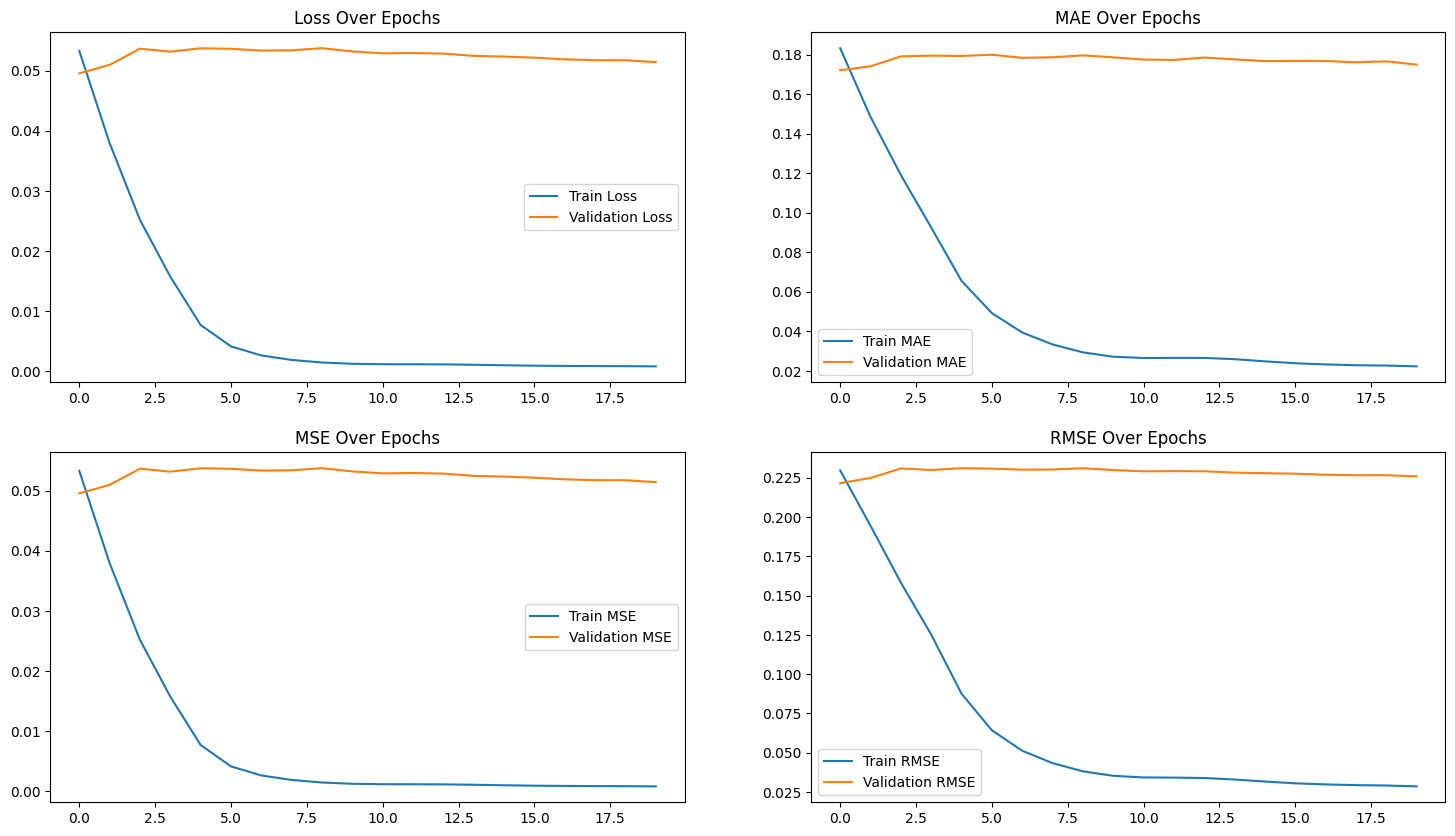

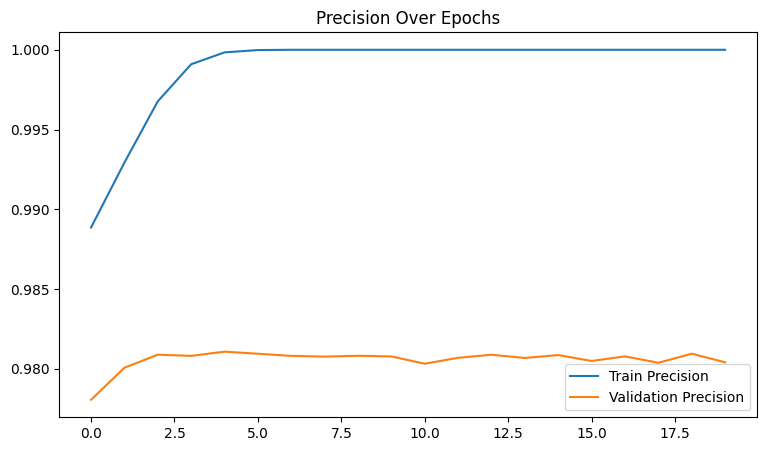

In [ ]:
visualize_results(history)

In [ ]:
# Select an exemplary user
exemplary_user_id = 4

# Encode the exemplary user ID
encoded_user_id = user_encoder.transform([exemplary_user_id])[0]

# Get a list of all movie IDs
all_movie_ids = df_movies['movie'].unique()

# Get the list of movies the user has already rated
rated_movies = df_ratings[df_ratings['userId'] == exemplary_user_id]['movieId'].unique()

# Filter out the movies the user has already rated
unrated_movie_ids = np.setdiff1d(all_movie_ids, rated_movies)

# Prepare input data for the model
user_input = np.full(len(unrated_movie_ids), encoded_user_id)
movie_input = unrated_movie_ids

# Convert to TensorFlow tensors
user_input_tensor = tf.convert_to_tensor(user_input, dtype=tf.int32)
movie_input_tensor = tf.convert_to_tensor(movie_input, dtype=tf.int32)

# Make predictions
predicted_ratings_scaled = model.predict([user_input_tensor, movie_input_tensor])
predicted_ratings = predicted_ratings_scaled * 4.5 + 0.5

# Combine movie IDs with their predicted ratings
movie_ratings = list(zip(movie_input, predicted_ratings.flatten()))

# Sort movies by predicted rating in descending order
sorted_movie_ratings = sorted(movie_ratings, key=lambda x: x[1], reverse=True)

# Get top-N recommendations
top_n = 10
top_n_recommendations = sorted_movie_ratings[:top_n]

# Print top-N recommendations
print(f"Top {top_n} movie recommendations for User {exemplary_user_id}:")
for i, (movie_id, predicted_rating) in enumerate(top_n_recommendations, start=1):
    original_movie_id = movie_encoder.inverse_transform([movie_id])[0]
    movie_title = df_movies[df_movies['movieId'] == original_movie_id]['title'].values[0]
    print(f"Rank {i}: Movie ID {original_movie_id}, Title: {movie_title}, Predicted Rating: {predicted_rating: .2f}")

289/289 [==============================] - 1s 2ms/step
Top 10 movie recommendations for User 4:
Rank 1: Movie ID 1020, Title: Cool Runnings, Predicted Rating:  4.38
Rank 2: Movie ID 1032, Title: Alice in Wonderland, Predicted Rating:  4.22
Rank 3: Movie ID 7181, Title: Ship of Fools, Predicted Rating:  4.22
Rank 4: Movie ID 807, Title: Rendezvous in Paris, Predicted Rating:  4.21
Rank 5: Movie ID 2619, Title: Mascara, Predicted Rating:  4.20
Rank 6: Movie ID 784, Title: The Cable Guy, Predicted Rating:  4.19
Rank 7: Movie ID 3221, Title: The Draughtsman's Contract, Predicted Rating:  4.14
Rank 8: Movie ID 2501, Title: October Sky, Predicted Rating:  4.12
Rank 9: Movie ID 2618, Title: The Castle, Predicted Rating:  4.11
Rank 10: Movie ID 1056, Title: Jude, Predicted Rating:  4.11


## 2.4 Harnessing larger datasets

Now, given the fact that Deep Neural Networks perform better and better the more data they are given, we will try our model with bigger datasets.

### 2.4.1 Define Functions

Now, let's define functions with the preprocessing and modelling steps which we did before.

In [ ]:
def prepare_data(df_ratings, df_movies):
  # Combine all movie IDs and user IDs from both dataframes to ensure comprehensive encoding
  all_movie_ids = pd.concat([df_ratings['movieId'], df_movies['movieId']]).unique()
  all_user_ids = df_ratings['userId'].unique()

  # Create and fit the encoders
  movie_encoder = LabelEncoder()
  user_encoder = LabelEncoder()

  movie_encoder.fit(all_movie_ids)
  user_encoder.fit(all_user_ids)

  # Transform movie and user IDs in the both dataframes
  df_ratings['user'] = user_encoder.transform(df_ratings['userId'])
  df_ratings['movie'] = movie_encoder.transform(df_ratings['movieId'])
  df_movies['movie'] = movie_encoder.transform(df_movies['movieId'])

  # Check Encoding:
  num_users = df_ratings['user'].nunique()
  num_movies = df_ratings['movie'].nunique()

  print("Unique users in ratings:", num_users)
  print("Unique movies in ratings:", num_movies)
  print("Min/Max user IDs:", df_ratings['user'].min(), '/', df_ratings['user'].max())
  print("Min/Max movie IDs:", df_ratings['movie'].min(), '/', df_ratings['movie'].max())

  # Recreate the mapping from the sorted unique IDs
  movie_id_map = {id: i for i, id in enumerate(sorted(df_ratings['movieId'].unique()))}

  # Apply the new mapping to the DataFrames
  df_ratings['movie'] = df_ratings['movieId'].apply(lambda x: movie_id_map.get(x, -1))  # Use get to avoid errors
  df_movies['movie'] = df_movies['movieId'].apply(lambda x: movie_id_map.get(x, -1))

  # Check again
  print("New max movie ID in ratings:", df_ratings['movie'].max())
  print("New unique movie IDs in ratings:", df_ratings['movie'].nunique())

  print(df_ratings[['movieId', 'movie']].head())
  print(df_movies[['movieId', 'movie']].head())

  # Ensure that all movies referenced in ratings are available in the movies DataFrame
  missing_movies = df_ratings[~df_ratings['movie'].isin(df_movies['movie'])]
  if missing_movies.empty:
      print("All movies in ratings are accounted for in the movies dataframe.")
  else:
      print(f"There are {missing_movies.shape[0]} missing movies in the movies dataframe.")

  # Removing ratings with missing movie metadata
  df_ratings = df_ratings[df_ratings['movie'].isin(df_movies['movie'])]

  # Check again
  missing_movies_after = df_ratings[~df_ratings['movie'].isin(df_movies['movie'])]
  if missing_movies_after.empty:
      print("All movies in ratings are now accounted for in the movies dataframe.")
  else:
      print(f"There are still {missing_movies_after.shape[0]} missing movies in the movies dataframe.")

  # Normalize the ratings to a scale of 0 to 1
  df_ratings['rating_norm'] = (df_ratings['rating'] - 0.5) / 4.5

  # Check Normalization:
  print("Min/Max normalized ratings:", df_ratings['rating_norm'].min(), "/", df_ratings['rating_norm'].max())
  print(df_ratings[['rating', 'rating_norm']].head())

  # Sort data chronologically
  df_ratings = df_ratings.sort_values(by='timestamp')

  # Define split ratios
  train_ratio = 0.7
  val_ratio = 0.15
  test_ratio = 0.15

  # Define a cutoff for splitting the data (70% train, 15% validation, 15% test)
  train_cutoff = int(len(df_ratings) * train_ratio)
  val_cutoff = int(len(df_ratings) * (train_ratio + val_ratio))

  train_df = df_ratings.iloc[:train_cutoff]
  val_df = df_ratings.iloc[train_cutoff:val_cutoff]
  test_df = df_ratings.iloc[val_cutoff:]

  # Separate user and item IDs for training, validation, and testing
  X_train_user = train_df['user'].values
  X_train_item = train_df['movie'].values
  y_train = train_df['rating_norm'].values

  X_val_user = val_df['user'].values
  X_val_item = val_df['movie'].values
  y_val = val_df['rating_norm'].values

  X_test_user = test_df['user'].values
  X_test_item = test_df['movie'].values
  y_test = test_df['rating_norm'].values

  # Convert to TensorFlow tensors
  X_train_user = tf.convert_to_tensor(X_train_user, dtype=tf.int32)
  X_train_item = tf.convert_to_tensor(X_train_item, dtype=tf.int32)
  y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)

  X_val_user = tf.convert_to_tensor(X_val_user, dtype=tf.int32)
  X_val_item = tf.convert_to_tensor(X_val_item, dtype=tf.int32)
  y_val = tf.convert_to_tensor(y_val, dtype=tf.float32)

  X_test_user = tf.convert_to_tensor(X_test_user, dtype=tf.int32)
  X_test_item = tf.convert_to_tensor(X_test_item, dtype=tf.int32)
  y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

  # Verify the shapes of the tensors
  print(f"X_train_user shape: {X_train_user.shape}")
  print(f"X_train_item shape: {X_train_item.shape}")
  print(f"y_train shape: {y_train.shape}")

  print(f"X_val_user shape: {X_val_user.shape}")
  print(f"X_val_item shape: {X_val_item.shape}")
  print(f"y_val shape: {y_val.shape}")

  print(f"X_test_user shape: {X_test_user.shape}")
  print(f"X_test_item shape: {X_test_item.shape}")
  print(f"y_test shape: {y_test.shape}")

  # Check Train-Test-Split:
  print("Train data range from {} to {}".format(train_df['timestamp'].min(), train_df['timestamp'].max()))
  print("Validation data range from {} to {}".format(val_df['timestamp'].min(), val_df['timestamp'].max()))
  print("Test data range from {} to {}".format(test_df['timestamp'].min(), test_df['timestamp'].max()))

  return X_train_user, X_train_item, y_train, X_val_user, X_val_item, y_val, X_test_user, X_test_item, y_test, user_encoder, movie_encoder

In [ ]:
def build_and_train_model(X_train_user, X_train_item, y_train, X_val_user, X_val_item, y_val, num_users, num_movies, embedding_size=10, epochs=20, batch_size=256):
    # GMF part
    user_input = Input(shape=(1,), name='user_input')
    item_input = Input(shape=(1,), name='item_input')

    user_embedding_gmf = Embedding(input_dim=num_users, output_dim=embedding_size, name='user_embedding_gmf')(user_input)
    item_embedding_gmf = Embedding(input_dim=num_movies, output_dim=embedding_size, name='item_embedding_gmf')(item_input)
    gmf_vector = Multiply()([Flatten()(user_embedding_gmf), Flatten()(item_embedding_gmf)])

    # MLP part
    user_embedding_mlp = Embedding(input_dim=num_users, output_dim=embedding_size, name='user_embedding_mlp')(user_input)
    item_embedding_mlp = Embedding(input_dim=num_movies, output_dim=embedding_size, name='item_embedding_mlp')(item_input)
    mlp_vector = Concatenate()([Flatten()(user_embedding_mlp), Flatten()(item_embedding_mlp)])

    mlp_vector = Dense(64, activation='relu')(mlp_vector)
    mlp_vector = Dense(32, activation='relu')(mlp_vector)
    mlp_vector = Dense(16, activation='relu')(mlp_vector)

    # Combine GMF and MLP parts
    concatenated = Concatenate()([gmf_vector, mlp_vector])
    result = Dense(10, activation='relu')(concatenated)
    output = Dense(1, activation='sigmoid')(result)

    # Define a custom RMSE metric
    def root_mean_squared_error(y_true, y_pred):
        return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

    model = Model(inputs=[user_input, item_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='mean_squared_error',
                  metrics=['mae', MeanSquaredError(name='mse'), root_mean_squared_error, Precision(thresholds=0.5, name='precision')])
    model.summary()

    # Train the model
    history = model.fit(
        [X_train_user, X_train_item],
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=([X_val_user, X_val_item], y_val)
    )

    return model, history

In [ ]:
def evaluate_model(model, X_test_user, X_test_item, y_test):
    # Evaluate model on the test set
    results = model.evaluate([X_test_user, X_test_item], y_test, verbose=1)

    # Scale back MAE, MSE, and RMSE to the original rating scale (0.5 to 5)
    scale_factor = 4.5
    scaled_mae = results[1] * scale_factor
    scaled_mse = results[2] * (scale_factor ** 2)
    scaled_rmse = results[3] * scale_factor

    # Print all metrics
    print("Test Loss (MSE): {:.4f}".format(results[0]))
    print("Test MAE: {:.4f}".format(scaled_mae))
    print("Test MSE: {:.4f}".format(scaled_mse))
    print("Test RMSE: {:.4f}".format(scaled_rmse))
    print("Test Precision: {:.2f}%".format(results[4] * 100))

In [ ]:
def get_recommendations_for_user(model, exemplary_user_id, user_encoder, movie_encoder, df_ratings, df_movies, top_n=10):
    # Encode the exemplary user ID
    encoded_user_id = user_encoder.transform([exemplary_user_id])[0]

    # Get a list of all movie IDs
    all_movie_ids = df_movies['movie'].unique()

    # Get the list of movies the user has already rated
    rated_movies = df_ratings[df_ratings['userId'] == exemplary_user_id]['movieId'].unique()

    # Filter out the movies the user has already rated
    unrated_movie_ids = np.setdiff1d(all_movie_ids, rated_movies)

    # Prepare input data for the model
    user_input = np.full(len(unrated_movie_ids), encoded_user_id)
    movie_input = unrated_movie_ids

    # Convert to TensorFlow tensors
    user_input_tensor = tf.convert_to_tensor(user_input, dtype=tf.int32)
    movie_input_tensor = tf.convert_to_tensor(movie_input, dtype=tf.int32)

    # Make predictions
    predicted_ratings_scaled = model.predict([user_input_tensor, movie_input_tensor])
    predicted_ratings = predicted_ratings_scaled * 4.5 + 0.5

    # Combine movie IDs with their predicted ratings
    movie_ratings = list(zip(movie_input, predicted_ratings.flatten()))

    # Sort movies by predicted rating in descending order
    sorted_movie_ratings = sorted(movie_ratings, key=lambda x: x[1], reverse=True)

    # Get top-N recommendations
    top_n_recommendations = sorted_movie_ratings[:top_n]

    # Print top-N recommendations
    print(f"Top {top_n} movie recommendations for User {exemplary_user_id}:")
    for i, (movie_id, predicted_rating) in enumerate(top_n_recommendations, start=1):
        original_movie_id = movie_encoder.inverse_transform([movie_id])[0]
        movie_title = df_movies[df_movies['movieId'] == original_movie_id]['title'].values[0]
        print(f"Rank {i}: Movie ID {original_movie_id}, Title: {movie_title}, Predicted Rating: {predicted_rating:.2f}")

### 2.4.2   1 Mio. Dataset

In [ ]:
# 1 Mio Ratings:

df_ratings = pd.read_pickle('/content/drive/My Drive/df_ratings_1M.pkl')

In [ ]:
# Prepare data
prepare_data(df_ratings, df_movies)

Unique users in ratings: 145430
Unique movies in ratings: 19596
Min/Max user IDs: 0 / 145429
Min/Max movie IDs: 0 / 40057
New max movie ID in ratings: 19595
New unique movie IDs in ratings: 19596
          movieId  movie
11800835     1037    985
3192182     27316   8398
10041143      307    302
14911364    73929  12086
13024846     4308   4059
   movieId  movie
0        1      0
1        2      1
2        3      2
3        4      3
4        5      4
There are 7743 missing movies in the movies dataframe.
All movies in ratings are now accounted for in the movies dataframe.
Min/Max normalized ratings: 0.0 / 1.0
          rating  rating_norm
11800835     0.5          0.0
3192182      0.5          0.0
10041143     0.5          0.0
14911364     0.5          0.0
13024846     0.5          0.0


<ipython-input-77-bc499fa49e4f>:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ratings['rating_norm'] = (df_ratings['rating'] - 0.5) / 4.5


X_train_user shape: (694580,)
X_train_item shape: (694580,)
y_train shape: (694580,)
X_val_user shape: (148839,)
X_val_item shape: (148839,)
y_val shape: (148839,)
X_test_user shape: (148839,)
X_test_item shape: (148839,)
y_test shape: (148839,)
Train data range from 1996-02-01 14:33:33 to 2011-04-28 02:16:07
Validation data range from 2011-04-28 02:18:17 to 2015-11-04 05:54:57
Test data range from 2015-11-04 06:02:22 to 2017-08-04 06:07:50


(<tf.Tensor: shape=(694580,), dtype=int32, numpy=array([ 51159, 116612, 123709, ...,  29189,  29189,  29189], dtype=int32)>,
 <tf.Tensor: shape=(694580,), dtype=int32, numpy=array([  62,   47,   86, ..., 8620, 6463, 2251], dtype=int32)>,
 <tf.Tensor: shape=(694580,), dtype=float32, numpy=
 array([0.11111111, 0.5555556 , 0.5555556 , ..., 0.7777778 , 0.7777778 ,
        0.44444445], dtype=float32)>,
 <tf.Tensor: shape=(148839,), dtype=int32, numpy=array([29189, 29189, 29189, ..., 46154, 46154, 73222], dtype=int32)>,
 <tf.Tensor: shape=(148839,), dtype=int32, numpy=array([ 1858,  9791, 11037, ...,  8748,  6607,  7728], dtype=int32)>,
 <tf.Tensor: shape=(148839,), dtype=float32, numpy=
 array([0.22222222, 0.6666667 , 0.6666667 , ..., 1.        , 1.        ,
        0.7777778 ], dtype=float32)>,
 <tf.Tensor: shape=(148839,), dtype=int32, numpy=array([ 79401,  46154,  79401, ..., 108576, 108576, 108576], dtype=int32)>,
 <tf.Tensor: shape=(148839,), dtype=int32, numpy=array([11238,   357,  46

In [ ]:
# Build and train the model
model, history = build_and_train_model(X_train_user, X_train_item, y_train, X_val_user, X_val_item, y_val, num_users, num_movies)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 item_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 user_embedding_mlp (Embedd  (None, 1, 10)                555880    ['user_input[0][0]']          
 ing)                                                                                             
                                                                                                  
 item_embedding_mlp (Embedd  (None, 1, 10)                94940     ['item_input[0][0]']    

In [ ]:
# Evaluate the model
evaluate_model(model, X_test_user, X_test_item, y_test)

466/466 [==============================] - 1s 2ms/step - loss: 0.0559 - mae: 0.1846 - mse: 0.0559 - root_mean_squared_error: 0.2333 - precision: 0.9767
Test Loss (MSE): 0.0559
Test MAE: 0.8308
Test MSE: 1.1311
Test RMSE: 1.0498
Test Precision: 97.67%


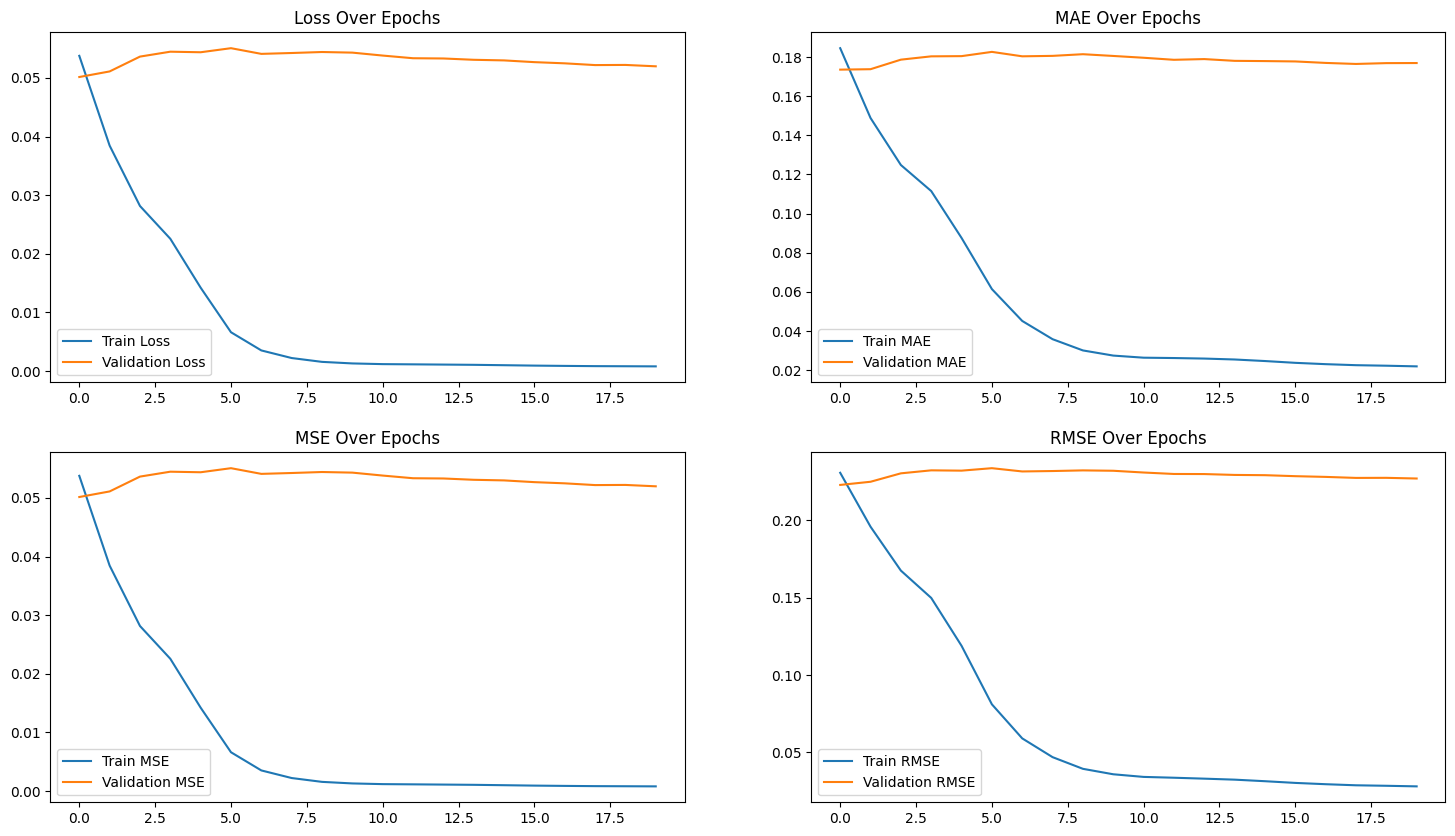

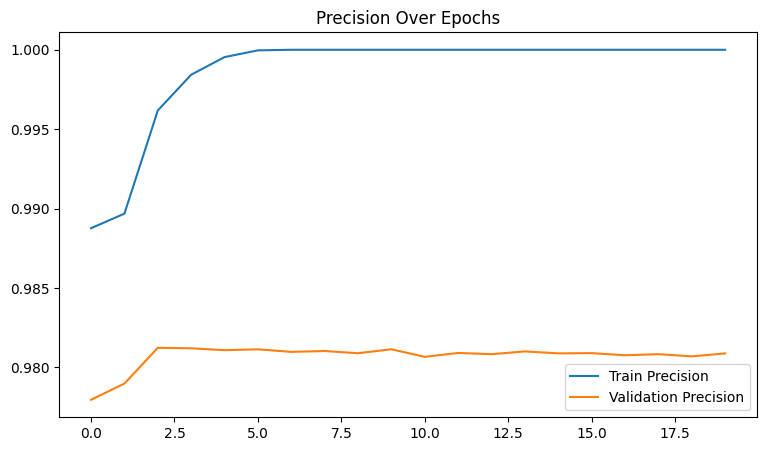

In [ ]:
visualize_results(history)

In [ ]:
# Get recommendations for an exemplary user
exemplary_user_id = 4
get_recommendations_for_user(model, exemplary_user_id, user_encoder, movie_encoder, df_ratings, df_movies)

575/575 [==============================] - 1s 2ms/step
Top 10 movie recommendations for User 4:
Rank 1: Movie ID 289, Title: Only You, Predicted Rating: 4.32
Rank 2: Movie ID 781, Title: Stealing Beauty, Predicted Rating: 4.26
Rank 3: Movie ID 1753, Title: Half Baked, Predicted Rating: 4.24
Rank 4: Movie ID 2496, Title: Blast from the Past, Predicted Rating: 4.23
Rank 5: Movie ID 482, Title: Killing Zoe, Predicted Rating: 4.23
Rank 6: Movie ID 2654, Title: The Wolf Man, Predicted Rating: 4.19
Rank 7: Movie ID 2615, Title: My Science Project, Predicted Rating: 4.19
Rank 8: Movie ID 7138, Title: El Bonaerense, Predicted Rating: 4.16
Rank 9: Movie ID 4397, Title: Cannonball Run II, Predicted Rating: 4.16
Rank 10: Movie ID 537, Title: Sirens, Predicted Rating: 4.14


### 2.4.3   3 Mio. Dataset

In [ ]:
# 3 Mio Ratings:

df_ratings = pd.read_pickle('/content/drive/My Drive/df_ratings_3M.pkl')

In [ ]:
# Prepare data
prepare_data(df_ratings, df_movies)

Unique users in ratings: 164638
Unique movies in ratings: 26876
Min/Max user IDs: 0 / 164637
Min/Max movie IDs: 0 / 41078
New max movie ID in ratings: 26875
New unique movie IDs in ratings: 26876
          movieId  movie
11800835     1037   1011
3192182     27316   9021
10041143      307    304
14911364    73929  13711
13024846     4308   4173
   movieId  movie
0        1      0
1        2      1
2        3      2
3        4      3
4        5      4
There are 22910 missing movies in the movies dataframe.
All movies in ratings are now accounted for in the movies dataframe.
Min/Max normalized ratings: 0.0 / 1.0
          rating  rating_norm
11800835     0.5          0.0
3192182      0.5          0.0
10041143     0.5          0.0
14911364     0.5          0.0
13024846     0.5          0.0


<ipython-input-77-bc499fa49e4f>:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ratings['rating_norm'] = (df_ratings['rating'] - 0.5) / 4.5


X_train_user shape: (2083963,)
X_train_item shape: (2083963,)
y_train shape: (2083963,)
X_val_user shape: (446564,)
X_val_item shape: (446564,)
y_val shape: (446564,)
X_test_user shape: (446564,)
X_test_item shape: (446564,)
y_test shape: (446564,)
Train data range from 1996-01-29 00:00:00 to 2011-04-29 02:10:57
Validation data range from 2011-04-29 02:11:19 to 2015-11-04 08:48:36
Test data range from 2015-11-04 08:48:45 to 2017-08-04 06:57:50


(<tf.Tensor: shape=(2083963,), dtype=int32, numpy=array([ 27632,  27632, 116093, ...,  54448,  87241,  54448], dtype=int32)>,
 <tf.Tensor: shape=(2083963,), dtype=int32, numpy=array([   1,   47,   10, ..., 1906, 6932,  373], dtype=int32)>,
 <tf.Tensor: shape=(2083963,), dtype=float32, numpy=
 array([0.7777778, 0.7777778, 0.7777778, ..., 0.5555556, 0.8888889,
        0.6666667], dtype=float32)>,
 <tf.Tensor: shape=(446564,), dtype=int32, numpy=array([54448, 33116, 54448, ..., 48681, 48681, 48681], dtype=int32)>,
 <tf.Tensor: shape=(446564,), dtype=int32, numpy=array([5120, 9183, 6469, ...,  471,    6, 5331], dtype=int32)>,
 <tf.Tensor: shape=(446564,), dtype=float32, numpy=
 array([0.5555556 , 0.7777778 , 0.44444445, ..., 0.22222222, 0.44444445,
        0.44444445], dtype=float32)>,
 <tf.Tensor: shape=(446564,), dtype=int32, numpy=array([103020,  48681,  48681, ..., 122806, 122806, 108999], dtype=int32)>,
 <tf.Tensor: shape=(446564,), dtype=int32, numpy=array([12423, 14954,  2820, ..., 

In [ ]:
# Build and train the model
model, history = build_and_train_model(X_train_user, X_train_item, y_train, X_val_user, X_val_item, y_val, num_users, num_movies)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 item_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 user_embedding_mlp (Embedd  (None, 1, 10)                555880    ['user_input[0][0]']          
 ing)                                                                                             
                                                                                                  
 item_embedding_mlp (Embedd  (None, 1, 10)                94940     ['item_input[0][0]']    

In [ ]:
# Evaluate the model
evaluate_model(model, X_test_user, X_test_item, y_test)

466/466 [==============================] - 1s 2ms/step - loss: 0.0562 - mae: 0.1842 - mse: 0.0562 - root_mean_squared_error: 0.2338 - precision: 0.9767
Test Loss (MSE): 0.0562
Test MAE: 0.8287
Test MSE: 1.1375
Test RMSE: 1.0519
Test Precision: 97.67%


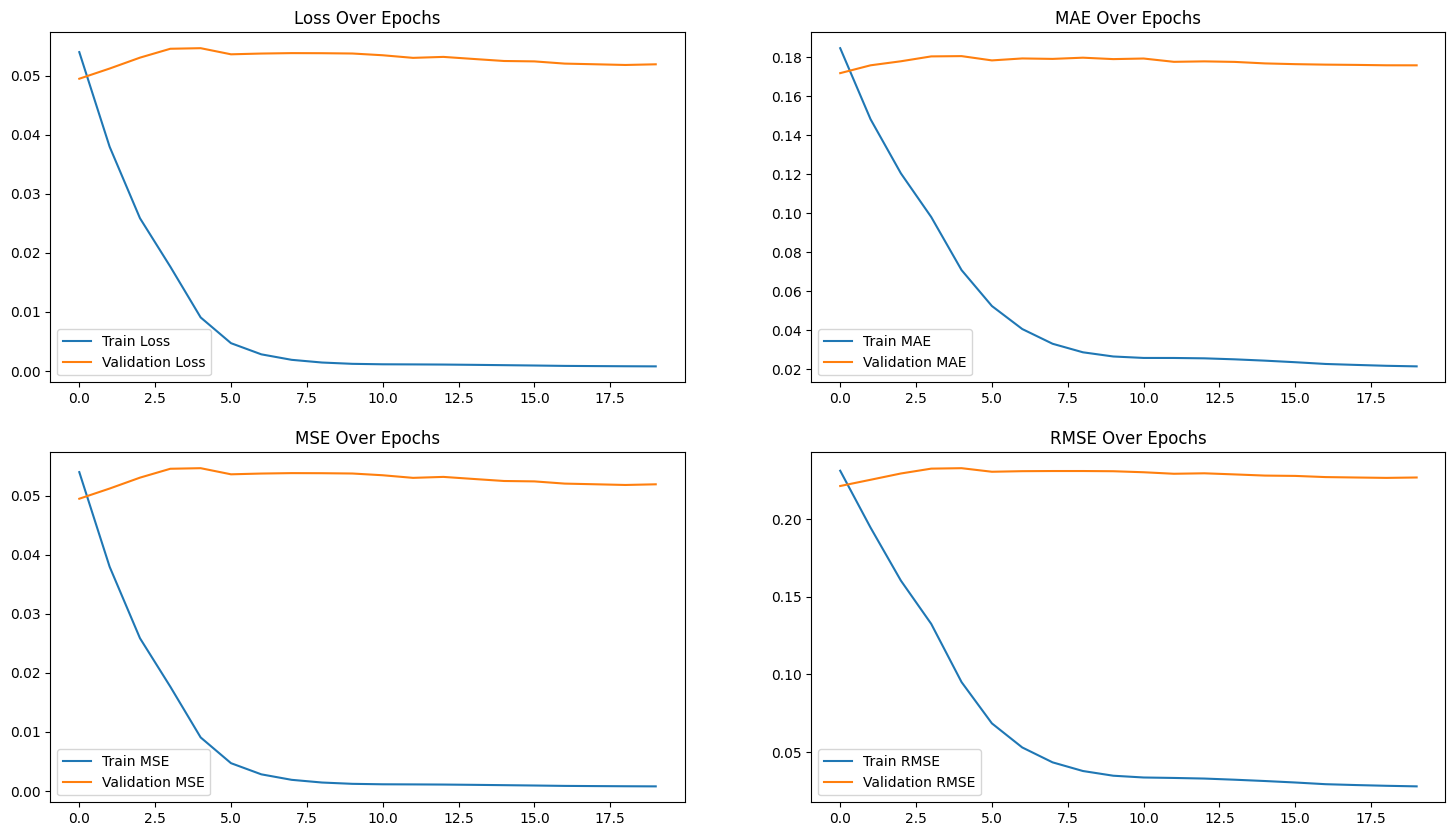

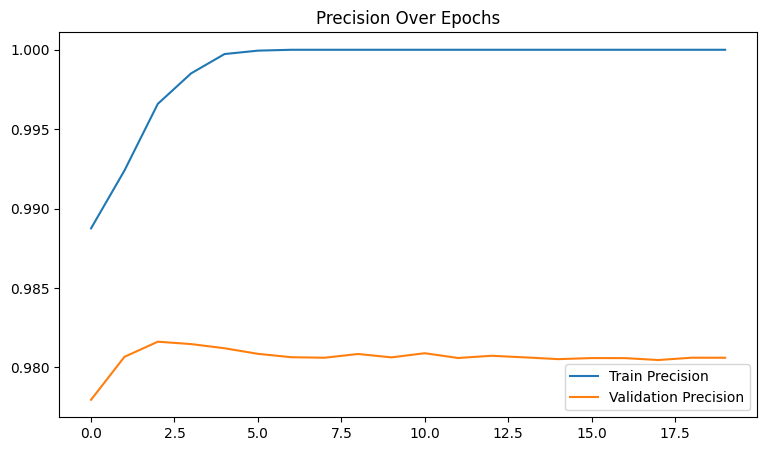

In [ ]:
visualize_results(history)

In [ ]:
# Get recommendations for an exemplary user
exemplary_user_id = 4
get_recommendations_for_user(model, exemplary_user_id, user_encoder, movie_encoder, df_ratings, df_movies)

771/771 [==============================] - 1s 2ms/step
Top 10 movie recommendations for User 4:
Rank 1: Movie ID 2496, Title: Blast from the Past, Predicted Rating: 4.48
Rank 2: Movie ID 2779, Title: Heaven Can Wait, Predicted Rating: 4.40
Rank 3: Movie ID 1015, Title: Homeward Bound: The Incredible Journey, Predicted Rating: 4.34
Rank 4: Movie ID 1753, Title: Half Baked, Predicted Rating: 4.33
Rank 5: Movie ID 289, Title: Only You, Predicted Rating: 4.31
Rank 6: Movie ID 2615, Title: My Science Project, Predicted Rating: 4.27
Rank 7: Movie ID 758, Title: The Jar, Predicted Rating: 4.23
Rank 8: Movie ID 2614, Title: Chopping Mall, Predicted Rating: 4.20
Rank 9: Movie ID 3961, Title: Ghoulies, Predicted Rating: 4.20
Rank 10: Movie ID 47, Title: Se7en, Predicted Rating: 4.17
